In [1]:
# ✨ 1. 설치
!pip install transformers datasets scikit-learn --quiet
!pip install --upgrade datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.32.4
    Uninstalling huggingface-hub-0.32.4:
      Successfully uninstalled huggingface-hub-0.32.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.

In [2]:
# ✨ 2. 라이브러리 로딩
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [3]:
# ✨ 3. 데이터 불러오기
dataset = load_dataset("klue", "ynat")
dataset = dataset.remove_columns(["guid"])  # 불필요한 열 제거


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.17M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'label', 'url', 'date'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['title', 'label', 'url', 'date'],
        num_rows: 9107
    })
})

In [5]:
print(dataset["train"].features)

{'title': Value(dtype='string', id=None), 'label': ClassLabel(names=['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치'], id=None), 'url': Value(dtype='string', id=None), 'date': Value(dtype='string', id=None)}


In [6]:
# train 세트에서 앞부분 5개 출력
for example in dataset["train"].select(range(5)):
    print(f"문장: {example['title']}")
    print(f"라벨: {example['label']} (→ {dataset['train'].features['label'].names[example['label']]})")
    print("-" * 50)

문장: 유튜브 내달 2일까지 크리에이터 지원 공간 운영
라벨: 3 (→ 생활문화)
--------------------------------------------------
문장: 어버이날 맑다가 흐려져…남부지방 옅은 황사
라벨: 3 (→ 생활문화)
--------------------------------------------------
문장: 내년부터 국가RD 평가 때 논문건수는 반영 않는다
라벨: 2 (→ 사회)
--------------------------------------------------
문장: 김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
라벨: 2 (→ 사회)
--------------------------------------------------
문장: 회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
라벨: 3 (→ 생활문화)
--------------------------------------------------


In [7]:
# ✨ 4. 라벨 이름 매핑 확인
label_list = dataset["train"].features["label"].names
print("라벨 목록:", label_list)

라벨 목록: ['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']


In [8]:
# ✨ 5. 토크나이저 준비
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/250k [00:00<?, ?B/s]

In [9]:
# ✨ 6. 토큰화 함수 정의
def preprocess(examples):
    return tokenizer(examples["title"], truncation=True, padding="max_length", max_length=128)

encoded_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/45678 [00:00<?, ? examples/s]

Map:   0%|          | 0/9107 [00:00<?, ? examples/s]

In [10]:
# ✨ 7. 데이터셋 형식 정리
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [11]:
# ✨ 8. 모델 준비
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list))

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# ✨ 9. 정확도 계산 함수
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [13]:
# ✨ 10. 훈련 설정
training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",  # ← 이 줄 추가: W&B 사용 안 함
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32 if torch.cuda.is_available() else 4,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
)

In [14]:
# ✨ 11. Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

In [15]:
# ✨ 12. 모델 학습 시작
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.487400,0.522449,0.815746
2,0.299000,0.474048,0.831448
3,0.154500,0.556133,0.833425


TrainOutput(global_step=4284, training_loss=0.3260887860138766, metrics={'train_runtime': 3028.5989, 'train_samples_per_second': 45.247, 'train_steps_per_second': 1.415, 'total_flos': 9014194745971200.0, 'train_loss': 0.3260887860138766, 'epoch': 3.0})

In [16]:
# ✨ 13. 평가
trainer.evaluate()

{'eval_loss': 0.47404801845550537,
 'eval_accuracy': 0.8314483364444932,
 'eval_runtime': 62.7212,
 'eval_samples_per_second': 145.198,
 'eval_steps_per_second': 4.544,
 'epoch': 3.0}

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 🔍 1. Validation 데이터에 대한 예측
pred_output = trainer.predict(encoded_dataset["validation"])
y_pred = np.argmax(pred_output.predictions, axis=1)
y_true = pred_output.label_ids

<ipython-input-18-3864721496>:8: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-3864721496>:8: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-3864721496>:8: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-3864721496>:8: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-3864721496>:8: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-3864721496>:8: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-3864721496>:8: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-386472

<Figure size 800x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

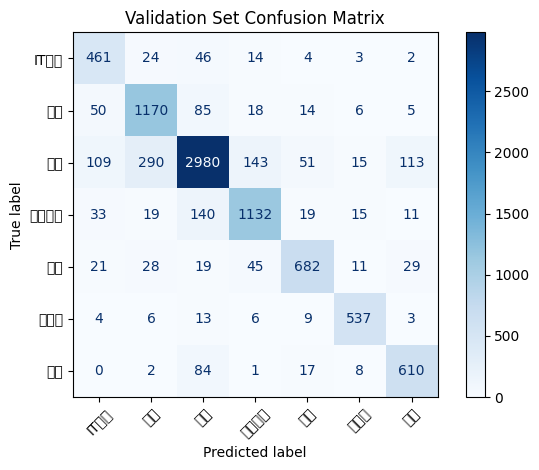

In [18]:
# 🔍 2. confusion matrix 계산 및 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

plt.figure(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Validation Set Confusion Matrix")
plt.tight_layout()
plt.show()

In [19]:
# 🔍 3. 클래스별 precision / recall / f1 출력
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_list, digits=3))


📊 Classification Report:
              precision    recall  f1-score   support

        IT과학      0.680     0.832     0.748       554
          경제      0.760     0.868     0.811      1348
          사회      0.885     0.805     0.843      3701
        생활문화      0.833     0.827     0.830      1369
          세계      0.857     0.817     0.836       835
         스포츠      0.903     0.929     0.916       578
          정치      0.789     0.845     0.816       722

    accuracy                          0.831      9107
   macro avg      0.815     0.846     0.829      9107
weighted avg      0.837     0.831     0.832      9107



#gradio를 통해 웹에서 테스트

In [20]:
print(trainer.state.best_model_checkpoint)

./results/checkpoint-2856


In [40]:
# 학습된 모델 불러오기

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 저장된 모델 경로 확인 (Trainer에서 저장된 경로)
model_path = "./results/checkpoint-2856"

# 토크나이저 및 모델 불러오기
tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-base")  # 또는 학습에 쓴 모델
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 라벨 리스트
label_list = dataset["train"].features["label"].names


In [41]:
# 뉴스 제목 추출 함수
import requests
from bs4 import BeautifulSoup

def extract_news_title(url):
    import requests
    from bs4 import BeautifulSoup

    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        res = requests.get(url, headers=headers, timeout=5)
        soup = BeautifulSoup(res.text, "html.parser")

        # 1. og:title
        og = soup.find("meta", property="og:title")
        if og and og.get("content"):
            return og["content"]

        # 2. 사이트별 커스텀 셀렉터
        selectors = [
            "#title_area > span",  # 네이버 뉴스
            "h1.title",            # 문화일보
            "#news-title",         # SBS
            ".tit.title_area",     # 뉴시스
            ".article_headline",   # 국민일보
            ".article-header__headline-container span",  # 조선비즈
            "h1.subject",          # 머니투데이
            ".headline-title"      # KBS
        ]

        for selector in selectors:
            el = soup.select_one(selector)
            if el and el.text.strip():
                return el.text.strip()

        # 3. fallback: 일반 title 태그
        if soup.title:
            return soup.title.string.strip()

        return "제목을 추출할 수 없습니다."
    except Exception as e:
        return f"[오류] 제목 추출 실패: {e}"



In [42]:
# 예측 함수
import torch

def predict_news_category_from_url(url):
    title = extract_news_title(url)
    if title.startswith("[오류]") or title == "제목을 추출할 수 없습니다.":
        return "오류", "오류"

    inputs = tokenizer(title, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    category = label_list[pred]
    return category, title  # 문자열 두 개를 튜플로 반환

In [43]:
import gradio as gr

with gr.Blocks(css="""
body {
    background-color: #1e1e1e;
    color: #ffffff;
    font-family: 'Segoe UI', sans-serif;
}
#main-container {
    max-width: 700px;
    margin: auto;
    padding-top: 40px;
}
.output-box {
    background-color: #ffffff;
    color: #000000;
    border-radius: 8px;
    padding: 12px;
    font-size: 16px;
    font-weight: bold;
    border: 1px solid #cccccc;
}
""") as demo:
    with gr.Column(elem_id="main-container"):
        gr.Markdown("## 📰 뉴스 주제 자동 분류기", elem_id="title")

        url_input = gr.Textbox(label="뉴스 기사 URL", placeholder="https://...")
        submit_btn = gr.Button("예측하기")

        gr.Markdown("#### 📌 예측 카테고리")
        category_output = gr.Textbox(label="", interactive=False, elem_classes=["block-box"])

        gr.Markdown("#### 📌 추출된 제목")
        title_output = gr.Textbox(label="", interactive=False, elem_classes=["block-box"])

        submit_btn.click(fn=predict_news_category_from_url, inputs=url_input, outputs=[category_output, title_output])

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a0e278c37a3b847bb1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [26]:
!zip -r checkpoint-2856.zip ./results/checkpoint-2856

  adding: results/checkpoint-2856/ (stored 0%)
  adding: results/checkpoint-2856/training_args.bin (deflated 52%)
  adding: results/checkpoint-2856/model.safetensors (deflated 7%)
  adding: results/checkpoint-2856/config.json (deflated 58%)
  adding: results/checkpoint-2856/trainer_state.json (deflated 65%)
  adding: results/checkpoint-2856/rng_state.pth (deflated 25%)
  adding: results/checkpoint-2856/scheduler.pt (deflated 55%)
  adding: results/checkpoint-2856/optimizer.pt (deflated 20%)


#final_model을 통해 실행

In [27]:
# trainer.save_model("final_model")

In [36]:
# 학습된 모델 불러오기

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 저장된 모델 경로 확인 (Trainer에서 저장된 경로)
model_path = "./final_model"

# 토크나이저 및 모델 불러오기
tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-base")  # 학습에 쓴 모델
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 라벨 리스트
label_list = dataset["train"].features["label"].names


In [37]:
# 뉴스 제목 추출 함수
import requests
from bs4 import BeautifulSoup

def extract_news_title(url):
    import requests
    from bs4 import BeautifulSoup

    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        res = requests.get(url, headers=headers, timeout=5)
        soup = BeautifulSoup(res.text, "html.parser")

        # 1. og:title
        og = soup.find("meta", property="og:title")
        if og and og.get("content"):
            return og["content"]

        # 2. 사이트별 커스텀 셀렉터
        selectors = [
            "#title_area > span",  # 네이버 뉴스
            "h1.title",            # 문화일보
            "#news-title",         # SBS
            ".tit.title_area",     # 뉴시스
            ".article_headline",   # 국민일보
            ".article-header__headline-container span",  # 조선비즈
            "h1.subject",          # 머니투데이
            ".headline-title"      # KBS
        ]

        for selector in selectors:
            el = soup.select_one(selector)
            if el and el.text.strip():
                return el.text.strip()

        # 3. fallback: 일반 title 태그
        if soup.title:
            return soup.title.string.strip()

        return "제목을 추출할 수 없습니다."
    except Exception as e:
        return f"[오류] 제목 추출 실패: {e}"



In [38]:
# 예측 함수
import torch

def predict_news_category_from_url(url):
    title = extract_news_title(url)
    if title.startswith("[오류]") or title == "제목을 추출할 수 없습니다.":
        return "오류", "오류"

    inputs = tokenizer(title, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    category = label_list[pred]
    return category, title  # 문자열 두 개를 튜플로 반환

In [39]:
import gradio as gr

with gr.Blocks(css="""
body {
    background-color: #1e1e1e;
    color: #ffffff;
    font-family: 'Segoe UI', sans-serif;
}
#main-container {
    max-width: 700px;
    margin: auto;
    padding-top: 40px;
}
.output-box {
    background-color: #ffffff;
    color: #000000;
    border-radius: 8px;
    padding: 12px;
    font-size: 16px;
    font-weight: bold;
    border: 1px solid #cccccc;
}
""") as demo:
    with gr.Column(elem_id="main-container"):
        gr.Markdown("## 📰 뉴스 주제 자동 분류기", elem_id="title")

        url_input = gr.Textbox(label="뉴스 기사 URL", placeholder="https://...")
        submit_btn = gr.Button("예측하기")

        gr.Markdown("#### 📌 예측 카테고리")
        category_output = gr.Textbox(label="", interactive=False, elem_classes=["block-box"])

        gr.Markdown("#### 📌 추출된 제목")
        title_output = gr.Textbox(label="", interactive=False, elem_classes=["block-box"])

        submit_btn.click(fn=predict_news_category_from_url, inputs=url_input, outputs=[category_output, title_output])

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://af230ae733caebff20.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
